In [1]:
# !pip install pandas numpy seaborn matplotlib scikit-learn

In [2]:
# pip list

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Step 1: Merge Actigraph Data
condition_folder = "data/condition"

In [5]:
"""
def merge_actigraph_data(folder_path):
    all_data = pd.DataFrame()  # Initialize an empty DataFrame
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            all_data = pd.concat([all_data, df], ignore_index=True)  # Concatenate data
    return all_data
"""

# Function to load data from condition CSV files
def load_condition_data(condition_folder):
    condition_data = pd.DataFrame()
    for file in os.listdir(condition_folder):
        if file.endswith(".csv"):
            condition_number = os.path.splitext(file)[0]  # Extract condition number from filename
            file_path = os.path.join(condition_folder, file)
            data = pd.read_csv(file_path)
            data['condition_number'] = condition_number  # Add a column to identify the condition number
            condition_data = pd.concat([condition_data, data], ignore_index=True)
    return condition_data

In [6]:
# control_data = merge_actigraph_data(control_folder)
# print(control_data)

# condition_data = merge_actigraph_data(condition_folder)
# condition_data

In [7]:
# Load condition data
condition_data = load_condition_data(condition_folder)
condition_data.head()

,timestamp,date,activity,condition_number
0,2002-06-06 13:00:00,2002-06-06,161,condition_23
1,2002-06-06 13:01:00,2002-06-06,80,condition_23
2,2002-06-06 13:02:00,2002-06-06,175,condition_23
3,2002-06-06 13:03:00,2002-06-06,728,condition_23
4,2002-06-06 13:04:00,2002-06-06,911,condition_23


In [8]:
condition_data['condition_number'] = condition_data['condition_number'].str.split('_').str[-1].astype(int)
condition_data = condition_data.sort_values(by='condition_number')
condition_data['condition_number'] = 'condition_' + condition_data['condition_number'].astype(str)
condition_data.reset_index(drop=True, inplace=True)
condition_data.head()

,timestamp,date,activity,condition_number
0,2003-05-19 05:11:00,2003-05-19,0,condition_1
1,2003-05-23 11:08:00,2003-05-23,0,condition_1
2,2003-05-23 11:07:00,2003-05-23,0,condition_1
3,2003-05-23 11:06:00,2003-05-23,0,condition_1
4,2003-05-23 11:05:00,2003-05-23,0,condition_1


In [9]:
# Step 2: Check for Missing Values
# print("Control Data - Missing Values:")
# print(control_data.isnull().sum())

# print("\nCondition Data - Missing Values:")
# condition_data.isnull().sum()

In [10]:
# Step 3: Convert Data Types
# control_data["timestamp"] = pd.to_datetime(control_data["timestamp"])
# condition_data["timestamp"] = pd.to_datetime(condition_data["timestamp"])

In [11]:
# Step 4: Correlational Analysis (After merging with scores.csv and performing imputation)
scores_file = "data/scores.csv"
scores_data = pd.read_csv(scores_file)
scores_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [12]:
# Drop rows where the 'number' column starts with 'control_'
scores_data = scores_data[~scores_data['number'].str.startswith('control_')]

# Reset index
scores_data.reset_index(drop=True, inplace=True)

scores_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [13]:
# Merge condition data with scores data using the 'number' column
condition_data_merged = pd.merge(condition_data, scores_data, left_on='condition_number', right_on='number', how='inner')

# Drop 'number' column
condition_data_merged = condition_data_merged.drop('number', axis=1)

# Display the merged data
condition_data_merged.head()

,timestamp,date,activity,condition_number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,2003-05-19 05:11:00,2003-05-19,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,2003-05-23 11:08:00,2003-05-23,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
2,2003-05-23 11:07:00,2003-05-23,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
3,2003-05-23 11:06:00,2003-05-23,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
4,2003-05-23 11:05:00,2003-05-23,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0


In [14]:
# Check for null values
condition_data_merged.isnull().any()

timestamp           False
date                False
activity            False
condition_number    False
days                False
gender              False
age                 False
afftype             False
melanch              True
inpatient           False
edu                 False
marriage            False
work                False
madrs1              False
madrs2              False
dtype: bool

In [15]:
"""
def impute_missing_values(data):
    # Separate numeric and categorical columns
    numeric_cols = data.select_dtypes(include=["number"]).columns
    categorical_cols = data.select_dtypes(include=["object"]).columns

    # Define imputers for numeric and categorical data
    numeric_imputer = SimpleImputer(
        strategy="mean"
    )  # Impute missing numeric values with mean
    categorical_imputer = SimpleImputer(
        strategy="most_frequent"
    )  # Impute missing categorical values with most frequent

    # Impute missing values based on data types
    data_numeric = data[numeric_cols].copy()
    data_categoric = data[categorical_cols].copy()

    data_numeric[:] = numeric_imputer.fit_transform(data_numeric)
    data_categoric[:] = categorical_imputer.fit_transform(data_categoric)

    # Combine imputed data back into a single DataFrame
    data_imputed = pd.concat([data_numeric, data_categoric], axis=1)

    return data_imputed
"""

'\ndef impute_missing_values(data):\n    # Separate numeric and categorical columns\n    numeric_cols = data.select_dtypes(include=["number"]).columns\n    categorical_cols = data.select_dtypes(include=["object"]).columns\n\n    # Define imputers for numeric and categorical data\n    numeric_imputer = SimpleImputer(\n        strategy="mean"\n    )  # Impute missing numeric values with mean\n    categorical_imputer = SimpleImputer(\n        strategy="most_frequent"\n    )  # Impute missing categorical values with most frequent\n\n    # Impute missing values based on data types\n    data_numeric = data[numeric_cols].copy()\n    data_categoric = data[categorical_cols].copy()\n\n    data_numeric[:] = numeric_imputer.fit_transform(data_numeric)\n    data_categoric[:] = categorical_imputer.fit_transform(data_categoric)\n\n    # Combine imputed data back into a single DataFrame\n    data_imputed = pd.concat([data_numeric, data_categoric], axis=1)\n\n    return data_imputed\n'

In [16]:
# condition_data_merged = impute_missing_values(condition_data_merged)

In [17]:
# Replace NaN and 3.0 values in the 'melanch' column with 2.0 (no melancholia) 
condition_data_merged['melanch'] = condition_data_merged['melanch'].fillna(2.0).replace(3.0, 0.0)
condition_data_merged.isnull().any()

timestamp           False
date                False
activity            False
condition_number    False
days                False
gender              False
age                 False
afftype             False
melanch             False
inpatient           False
edu                 False
marriage            False
work                False
madrs1              False
madrs2              False
dtype: bool

In [18]:
condition_corr = condition_data_merged[["activity", "madrs1", "madrs2"]].corr()
print("Correlation Matrix within the Condition Group:")
condition_corr

Correlation Matrix within the Condition Group:


,activity,madrs1,madrs2
activity,1.000000,0.020423,0.016807
madrs1,0.020423,1.000000,0.600314
madrs2,0.016807,0.600314,1.000000


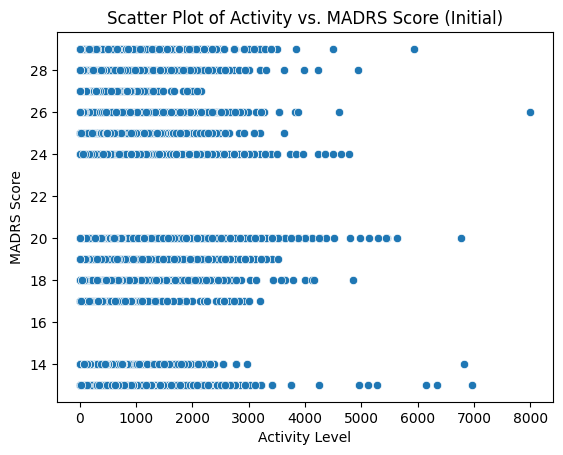

In [19]:
# Step 5: Visualization - Scatter Plot
sns.scatterplot(data=condition_data_merged, x="activity", y="madrs1")
plt.title("Scatter Plot of Activity vs. MADRS Score (Initial)")
plt.xlabel("Activity Level")
plt.ylabel("MADRS Score")
plt.show()

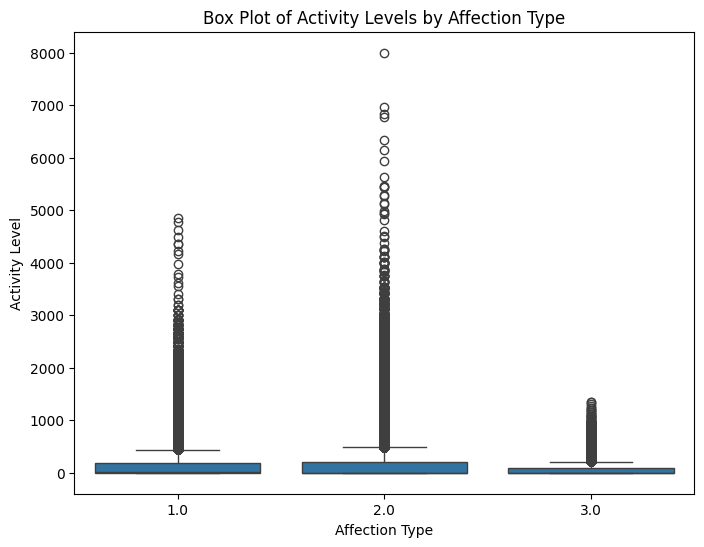

In [20]:
# Step 6: Group Comparisons - Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=condition_data_merged, x="afftype", y="activity")
plt.title("Box Plot of Activity Levels by Affection Type")
plt.xlabel("Affection Type")
plt.ylabel("Activity Level")
plt.show()

In [21]:
# Step 7: Regression Analysis
X = condition_data_merged[["activity"]]
y = condition_data_merged["madrs1"]  # Assuming using initial MADRS score for analysis

In [22]:
# TODO: SCALING/ENCODING
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
# Make predictions
y_pred = model.predict(X_test)

In [25]:
# Evaluate model
print("\nLinear Regression Model Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Linear Regression Model Performance:
Mean Squared Error: 24.28569576231689
R-squared: 0.0003328799795868642


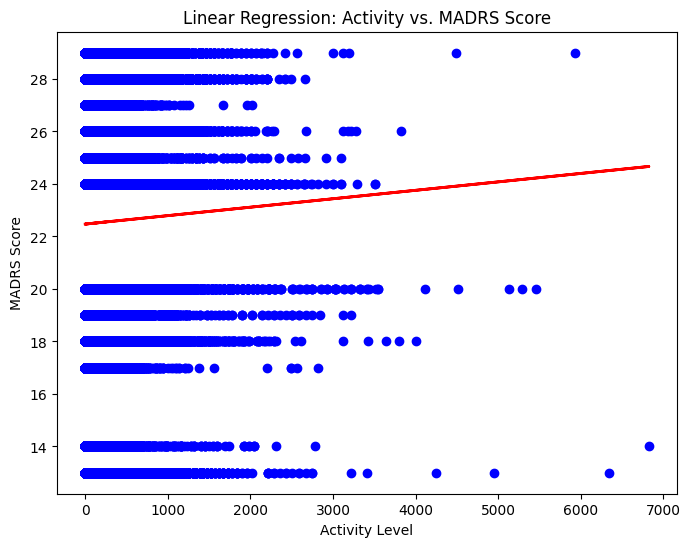

In [26]:
# Step 8: Visualization - Regression Line
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color="blue")
plt.plot(X_test, y_pred, color="red", linewidth=2)
plt.title("Linear Regression: Activity vs. MADRS Score")
plt.xlabel("Activity Level")
plt.ylabel("MADRS Score")
plt.show()